# Mini Gato

Goals:

- Simplicity
- Minimal dependencies
- Clear explanations
- Quickly iterable executable examples
- Extensible architecture

Non-goals:

- Performance
- Eval metrics

If I succeed at the goals then I expect the path towards the non-goals will be clear.

### Definitions

- ***ModalBatch*** a batch of samples of some modality
- ***ModalSample*** an individual data sample of some modality
- ***TextSample*** sample of text modality
- ***VQASample*** sample of visual question answering
- ***ActionSample*** sample of a visual (and maybe proprioception) task predicting action towards a provided textual goal
  - The Gato paper differentiates between image/discrete tasks and image/proprioception/discrete/continuous tasks. I'm going to lump those two together. Continuous values get binned into one of 1024 discrete bins, before they get embedded. So we funnel the behavior into the same channel.
  

In [1]:
import os
from pathlib import Path
import re
import tempfile
import requests

def acquire_shakespeare_dataset():
    temp_dir = tempfile.gettempdir()
    shakespeare_filepath = Path(temp_dir)/"shakespeare.txt"
    if not os.path.exists(shakespeare_filepath):
        data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
        with open(shakespeare_filepath, 'w', encoding='utf-8') as f:
            f.write(requests.get(data_url).text)
    
    with open(shakespeare_filepath, 'r', encoding='utf-8') as f:
        data = f.read()

    # Split the dataset into each character's lines.
    # Continue taking lines until you have at least 250 words in the sample.
    # Add that sample to the dataset.
    characters_lines = re.split(r"\n\s*\n", data.strip())
    MIN_WORDS_PER_BATCH = 250
    sample = [characters_lines[0]]
    num_words_in_sample = len(characters_lines[0].split())
    text_dataset = []
    i = 1
    while i < len(characters_lines):
        if num_words_in_sample > MIN_WORDS_PER_BATCH:
            text_dataset.append("\n\n".join(sample))
            num_words_in_sample -= len(sample[0].split())
            sample = sample[1:]
        sample += [characters_lines[i]]
        num_words_in_sample += len(characters_lines[i].split())
        i += 1

    return text_dataset

In [2]:
text_dataset = acquire_shakespeare_dataset()

In [3]:
print(f"Number of samples in the dataset: {len(text_dataset)}")
print(f"Character length of first 3 samples: {[len(x) for x in text_dataset[:3]]}\n")
print(f"First 80 characters of first sample:\n\n{text_dataset[0][:80]}")

Number of samples in the dataset: 7184
Character length of first 3 samples: [1632, 1688, 1891]

First 80 characters of first sample:

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.


### Text Tokenization

> Text tokens, discrete and continuous values, and actions can be directly set as targets after tokenization. [§ 2.2](https://arxiv.org/pdf/2205.06175#page=4)

I think it's going to simplify things if we combine into a single concept all of tokenization, target-setting, and masking.

The idea is: we call something like `text_token_prep` or `image_token_prep` and it returns the tokens, the targets, and the attention masks. No matter the modality, we always get those three things returned.

Let's write that in such a way that we get the benefit of things like autocomplete.

In [4]:
SEQUENCE_LENGTH = 1024
BATCH_SIZE = 4
NUM_WORKERS = 4  # DataLoader

In [113]:
from abc import ABC, abstractmethod
from typing import Protocol, runtime_checkable, NewType
from dataclasses import dataclass
from functools import partial
import torch

@dataclass
class TokenData:
    tokens: torch.Tensor = torch.tensor([], dtype=torch.float32)
    targets: torch.Tensor = torch.tensor([], dtype=torch.int64)
    attention_mask: torch.Tensor = torch.tensor([], dtype=torch.uint8)

    def to(self, device):
        self.tokens = self.tokens.to(device)
        self.targets = self.targets.to(device)
        self.attention_mask = self.attention_mask.to(device)
        return self

class TextTokenData(TokenData):
    pass

class ImageTokenData(TokenData):
    pass
# etc... I don't know exactly what all types we'll need for this.
# 
# Example: will we need a single VisualQuestionAnsweringTokenData?
# Or, will that be a concatenation of TextTokenData and ImageTokenData?
# I just don't know yet.

In [75]:
class Tokenator(ABC):
    @abstractmethod
    def __call__(self) -> TokenData:
        pass

class TextTokenator(Tokenator):
    def __init__(self, tokenizer):   
        self.tokenizer = tokenizer
        
    def __call__(self, batch, **kwargs) -> TokenData:
        tokenized =  self.tokenizer(batch, **kwargs)
        xs = tokenized["input_ids"][:, :-1]
        ms = tokenized["attention_mask"][:, :-1]
        ys = tokenized["input_ids"][:, 1:]
        return TextTokenData(tokens=xs, targets=ys, attention_mask=ms)

    def decode(self, *args, **kwargs):
        return self.tokenizer.func.decode(*args, **kwargs)

    @property
    def vocab_size(self):
        return self.tokenizer.func.vocab_size

In [76]:
from transformers import GPT2Tokenizer

In [114]:
# Prefixing with _ to signify global.
__text_tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2", clean_up_tokenization_spaces=True)
__text_tokenizer.pad_token = __text_tokenizer.eos_token
_text_tokenizer = partial(
    __text_tokenizer,
    max_length=SEQUENCE_LENGTH+1,
    truncation=True,
    padding="max_length",
    return_tensors="pt",
)

In [115]:
text_tokenator = TextTokenator(_text_tokenizer)

In [116]:
text_tokenator(["Hello, world!"])

TextTokenData(tokens=tensor([[15496,    11,   995,  ..., 50256, 50256, 50256]]), targets=tensor([[   11,   995,     0,  ..., 50256, 50256, 50256]]), attention_mask=tensor([[1, 1, 1,  ..., 0, 0, 0]]))

In [117]:
from torch.utils.data import DataLoader

In [118]:
text_dataloader = DataLoader(text_dataset, batch_size=BATCH_SIZE, collate_fn=text_tokenator)

In [119]:
text_tokens = next(iter(text_dataloader))

In [120]:
text_tokens.tokens.shape, text_tokens.targets.shape, text_tokens.attention_mask.shape

(torch.Size([4, 1024]), torch.Size([4, 1024]), torch.Size([4, 1024]))

Make sure the 4th element of our target matches what we expect to be predicted after the 4th element of our input. We're tokenizing and offsetting correctly.

In [121]:
text_dataset[0][:30]

'First Citizen:\nBefore we proce'

In [122]:
text_tokens.tokens[0, :5], text_tokens.targets[0, :4]

(tensor([ 5962, 22307,    25,   198,  8421]),
 tensor([22307,    25,   198,  8421]))

In [123]:
text_tokenator.decode(text_tokens.tokens[0, :5]), text_tokenator.decode(text_tokens.targets[0, 4])

('First Citizen:\nBefore', ' we')

### Does it work with multiple workers?

In [124]:
text_dataloader = DataLoader(text_dataset, batch_size=BATCH_SIZE, collate_fn=text_tokenator, num_workers=4)
dl = iter(text_dataloader)

In [125]:
from tqdm.notebook import tqdm

In [126]:
for _ in tqdm(range(100)):
    next(dl)

  0%|          | 0/100 [00:00<?, ?it/s]

In [127]:
for _ in tqdm(range(100)):
    next(dl)

  0%|          | 0/100 [00:00<?, ?it/s]

In [128]:
import torch.nn as nn
from transformers import GPT2TokenizerFast, GPT2Config, GPT2Model

In [129]:
EMBEDDING_DIM = 768
PATCH_SIZE = 16
class MiniGato(nn.Module):
    def __init__(
        self,
        transformer=None,
        text_tokenator=None,
        sequence_length=SEQUENCE_LENGTH,
        embedding_dim=EMBEDDING_DIM,
        patch_size=PATCH_SIZE,
    ):
        super().__init__()
        assert text_tokenator, "text_tokenizer is a required arg"
        self.embedding_dim = embedding_dim
        self.text_tokenator = text_tokenator
        self.text_embedding = nn.Embedding(
            self.vocab_size,
            self.embedding_dim,
        )

        self.transformer = transformer
        self.lm_head = nn.Linear(self.transformer.config.hidden_size, self.text_tokenator.vocab_size)

    @property
    def vocab_size(self):
        return self.text_tokenator.vocab_size

    def embed_text(self, tokens):
        return self.text_embedding(tokens)

    def forward(self, tokens):
        text_tokens = next((t for t in tokens if isinstance(t, TextTokenData)), [])
        text_embeddings = self.text_embedding(text_tokens.tokens)
        transformed = self.transformer(inputs_embeds=text_embeddings)
        out = self.lm_head(transformed.last_hidden_state)
        return out

In [130]:
configuration = GPT2Config(
    n_embd=EMBEDDING_DIM
)
transformer = GPT2Model(configuration)
model = MiniGato(transformer=transformer, text_tokenator=text_tokenator)

In [131]:
tokens = _text_tokenizer(["hello, world", "foobar"], return_tensors="pt", padding="max_length", max_length=8)
model.text_embedding(tokens["input_ids"]).shape

torch.Size([2, 8, 768])

In [132]:
out = model([next(dl)])

In [133]:
type(out), out.shape

(torch.Tensor, torch.Size([4, 1024, 50257]))

In [134]:
## Loss
##
## See section 2.3 of the Gato paper.
##
##   Let b index a training batch of sequences B. We define a masking function m
##   such that m(b, l) = 1 if the token at index l is either from text or from
##   the logged action of an agent, and 0 otherwise. The training loss for a
##   batch B can then be written as...
def cross_entropy(predicted, target, mask):
    # See: https://youtu.be/kCc8FmEb1nY?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&t=1553
    B, T, C = predicted.shape
    predicted = predicted.view(B * T, C)
    target = target.view(-1)
    losses = F.cross_entropy(predicted, target, reduction="none")
    losses = losses * mask.squeeze(-1).view(-1)
    loss = losses.sum() / mask.sum()
    return loss

In [135]:
device = torch.device('cuda')

In [136]:
def init_model():
    configuration = GPT2Config(
        n_embd=EMBEDDING_DIM
    )
    transformer = GPT2Model(configuration)
    model = MiniGato(transformer=transformer, text_tokenator=text_tokenator)
    return model

In [137]:
model = init_model().to(device)

In [138]:
model

MiniGato(
  (text_embedding): Embedding(50257, 768)
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=True)
)

In [139]:
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):.2e}")

Number of parameters: 2.02e+08


In [140]:
def init_optimizer(params):
    optimizer = torch.optim.AdamW(params)
    return optimizer

optimizer = init_optimizer(model.parameters())

In [141]:
from tqdm.notebook import tqdm

In [142]:
def fresh_text_dataloader():
    return DataLoader(text_dataset, batch_size=BATCH_SIZE, collate_fn=text_tokenator, num_workers=4)
text_dataloader_iter = iter(fresh_text_dataloader())    

In [143]:
text_token_data = next(text_dataloader_iter)

In [144]:
import torch.nn.functional as F

In [251]:
import gc
torch.cuda.empty_cache()
gc.collect()

2890

In [252]:
# Step by step.
model.train()
text_dataloader_iter = iter(fresh_text_dataloader())
text_token_data = next(text_dataloader_iter)

### Does it work? Can we overfit?

In [253]:
text_token_data.tokens

tensor([[ 5962, 22307,    25,  ..., 50256, 50256, 50256],
        [ 3237,    25,   198,  ..., 50256, 50256, 50256],
        [ 5962, 22307,    25,  ..., 50256, 50256, 50256],
        [ 3237,    25,   198,  ..., 50256, 50256, 50256]])

In [254]:
model.text_tokenator.decode(text_token_data.tokens[0])

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger 

In [255]:
model.train()

MiniGato(
  (text_embedding): Embedding(50257, 768)
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=True)
)

In [257]:
for _ in tqdm(range(100)):
    text_token_data.tokens = text_token_data.tokens.to(device)
    text_token_data.targets = text_token_data.targets.to(device)
    text_token_data.attention_mask = text_token_data.attention_mask.to(device)
    
    x = [text_token_data]  # Model branches of type to embed, so we can't send just `.tokens`.
    y = torch.concat([text_token_data.targets])
    m = torch.concat([text_token_data.attention_mask])
    optimizer.zero_grad()
    # forward
    text_tokens = next((t for t in x if isinstance(t, TextTokenData)), [])
    text_embeddings = model.text_embedding(text_tokens.tokens)
    transformed = model.transformer(inputs_embeds=text_embeddings)  # Would be stacked with other modalities.
    p = model.lm_head(transformed.last_hidden_state)
    # The above is effectively `p = model(x)`
    
    loss = cross_entropy(p, y, m)
    loss.backward()
    optimizer.step()

  0%|          | 0/100 [00:00<?, ?it/s]

In [223]:
model.text_tokenator([text]).to(device)

TextTokenData(tokens=tensor([[ 5962, 22307,    25,  ..., 50256, 50256, 50256]], device='cuda:0'), targets=tensor([[22307,    25,   628,  ..., 50256, 50256, 50256]], device='cuda:0'), attention_mask=tensor([[1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'))

In [266]:
model.eval()
text = "First Citizen:"
token = None
i = 0
with torch.no_grad():
    while i < 20 and token != model.text_tokenator.tokenizer.func.eos_token_id:
        token_data = model.text_tokenator([text]).to(device)
        length = token_data.attention_mask.sum().item()
        p = model([token_data])
        # chosen = torch.multinomial(p.softmax(dim=2)[:, length-1], num_samples=1)
        # with temperature
        heat = 0.1
        heated = p / heat
        chosen = torch.multinomial(heated.softmax(dim=2)[:, length-1], num_samples=1)
        token = chosen[0]
        text += model.text_tokenator.decode(chosen[0])
        i += 1
print(text)

First Citizen:
You are all resolved rather to die than to famish?

 to the people.



In [267]:
def train(model, optimizer):
    i = 100
    text_i = 0
    model.train()
    text_dataloader_iter = iter(fresh_text_dataloader())
    for epoch in tqdm(range(i)):
        try:
            text_token_data = next(text_dataloader_iter)
        except StopIteration:
            text_i += 1
            text_dataloader_iter = iter(fresh_text_dataloader())
            text_token_data = next(text_dataloader_iter)
        text_token_data.tokens = text_token_data.tokens.to(device)
        text_token_data.targets = text_token_data.targets.to(device)
        text_token_data.attention_mask = text_token_data.attention_mask.to(device)
        # Eventually we'll have other modalities' dataloaders and we'll concat their results below.
        x = [text_token_data]  # Model branches of type to embed.
        y = torch.concat([text_token_data.targets])
        m = torch.concat([text_token_data.attention_mask])
        optimizer.zero_grad()
        p = model(x)
        loss = cross_entropy(p, y, m)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{i}], Loss: {loss.item()}")
    print(f"Epoch [{epoch}/{i}], Loss: {loss.item()}")
    print(f"text: {text_i}")

In [395]:
train(model, optimizer)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [0/100], Loss: 5.402276515960693
Epoch [10/100], Loss: 5.388052463531494
Epoch [20/100], Loss: 6.653019905090332
Epoch [30/100], Loss: 5.597199440002441
Epoch [40/100], Loss: 6.08368444442749
Epoch [50/100], Loss: 5.975568771362305
Epoch [60/100], Loss: 5.656105995178223
Epoch [70/100], Loss: 5.5299530029296875
Epoch [80/100], Loss: 5.9142537117004395
Epoch [90/100], Loss: 5.648364067077637
Epoch [99/100], Loss: 5.458223819732666
text: 0


# VQA

In [268]:
import random
import datasets
import torchvision.transforms.v2 as transforms
import matplotlib.pyplot as plt

In [269]:
vqa_dataset = datasets.load_dataset("eihli/micro-ok-vqa").with_format("pt")

In [270]:
vqa_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'question_type', 'confidence', 'answers', 'image_id', 'answer_type', 'question_id', 'question'],
        num_rows: 80
    })
    validation: Dataset({
        features: ['image', 'question_type', 'confidence', 'answers', 'image_id', 'answer_type', 'question_id', 'question'],
        num_rows: 20
    })
})

In [271]:
vqa_dataset["train"]

Dataset({
    features: ['image', 'question_type', 'confidence', 'answers', 'image_id', 'answer_type', 'question_id', 'question'],
    num_rows: 80
})

In [272]:
vqa_dataset['train']['image'][0].shape

torch.Size([3, 479, 640])

In [273]:
vqa_dataset["train"]["question"][:5]

['What is the hairstyle of the blond called?',
 'How old do you have to be in canada to do this?',
 'Can you guess the place where the man is playing?',
 'Which rail company is named after a town in new mexico?',
 'Is the boy swimming or doing another water activity?']

In [274]:
len(vqa_dataset["train"]["answers"][0]), vqa_dataset["train"]["answers"][0][:3]

(10,
 [{'answer': 'pony tail',
   'raw_answer': 'pony tail',
   'answer_confidence': 'yes',
   'answer_id': tensor(1)},
  {'answer': 'pony tail',
   'raw_answer': 'pony tail',
   'answer_confidence': 'yes',
   'answer_id': tensor(2)},
  {'answer': 'pony tail',
   'raw_answer': 'pony tail',
   'answer_confidence': 'yes',
   'answer_id': tensor(3)}])

In [307]:
# First things first, let's get the images resized, cropped, and normalized.

vqa_transform = transforms.Compose([
    # No particular reason to use `transforms.Compose` here since we're only doing one transform. But it's nice to know about.
    transforms.RandomResizedCrop((192, 192), (0.5, 1.0)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])    
])

In [308]:
from torch.utils.data import Dataset

In [316]:
class TransformDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        answer = random.choice(item["answers"])["answer"]
        question = item["question"]
        image = self.transform(item["image"])        
        return {
            "question": question,
            "image": image,
            "answer": answer,
        }        

transformed_vqa_dataset = TransformDataset(vqa_dataset["train"], vqa_transform)

In [317]:
def micro_ok_vqa_collate_fn(batch):
    answers = [random.choice(el["answers"])["answer"] for el in batch]
    questions = [el["question"] for el in batch]
    images = torch.stack([micro_ok_vqa_transform(el["image"]) for el in batch])
    return {
        "question": questions,
        "image": images,
        "answer": answers,
    }

In [318]:
transformed_vqa_dataset[0]["image"]

tensor([[[-2.0494, -2.0494, -2.0323,  ..., -1.3473, -1.2788, -1.3130],
         [-2.0494, -2.0323, -2.0837,  ..., -1.0219, -1.0219, -1.0904],
         [-2.0665, -2.0494, -2.0837,  ..., -1.0390, -1.0904, -1.0390],
         ...,
         [ 0.7077,  0.6049,  0.5193,  ...,  0.9132,  0.8618,  0.6906],
         [ 0.6906,  0.5364,  0.4679,  ...,  1.2385,  1.1187,  1.0331],
         [ 0.7248,  0.5536,  0.5022,  ...,  1.4612,  1.4440,  1.4783]],

        [[-0.8452, -0.8452, -0.8452,  ..., -0.1800, -0.1625, -0.1800],
         [-0.8803, -0.8627, -0.8803,  ..., -0.1625, -0.1450, -0.1450],
         [-0.9153, -0.8803, -0.8978,  ..., -0.2850, -0.3025, -0.2675],
         ...,
         [ 0.5028,  0.3627,  0.2052,  ...,  0.3978,  0.3978,  0.2927],
         [ 0.5028,  0.3277,  0.1702,  ...,  1.1681,  1.0280,  0.9580],
         [ 0.5203,  0.3277,  0.2052,  ...,  1.6758,  1.6583,  1.6933]],

        [[ 0.1128,  0.1128,  0.1302,  ...,  0.4265,  0.4265,  0.4265],
         [ 0.1128,  0.1128,  0.0779,  ...,  0

In [319]:
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import transforms

# Load pre-trained ResNet18
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

In [320]:
class ImageTokenator(Tokenator):
    def __init__(self, tokenizer):   
        self.tokenizer = tokenizer
        
    def __call__(self, batch, **kwargs) -> TokenData:
        tokenized =  self.tokenizer(batch, **kwargs)
        xs = tokenized["input_ids"][:, :-1]
        # We're not predicting image tokens, so zero out the attention and predictions.
        ms = ys = torch.zeros(xs.shape[:2])
        return ImageTokenData(tokens=xs, targets=ys, attention_mask=ms)

In [31]:
vqa_dl = DataLoader(vqa_dataset["train"], batch_size=BATCH_SIZE, collate_fn=micro_ok_vqa_collate_fn, num_workers=4)

In [32]:
dl = iter(vqa_dl)

In [33]:
vqa_batch = next(dl)

In [34]:
vqa_batch["image"].shape

torch.Size([4, 3, 192, 192])

In [35]:
from einops import rearrange

In [36]:
PATCH_SIZE = 12

In [37]:
images = vqa_batch["image"]

In [38]:
patches = rearrange(images, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=PATCH_SIZE, s2=PATCH_SIZE)
patches.shape

torch.Size([4, 256, 432])

In [39]:
patches_matplotlib_dims = rearrange(images, 'b c (h s1) (w s2) -> b (h w) s1 s2 c', s1=PATCH_SIZE, s2=PATCH_SIZE)
patches.shape

torch.Size([4, 256, 432])

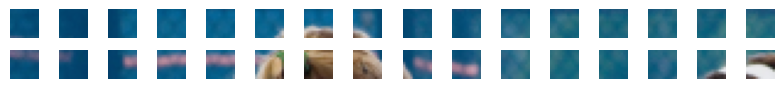

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=16, figsize=(8, 1))

for i in range(2):
    for j in range(16):
        axes[i, j].imshow(patches_matplotlib_dims[0][i * 16 + j])
        axes[i, j].axis("off")
plt.tight_layout()
plt.show()

In [41]:
reconstructed = rearrange(patches, 'b (ph pw) (sh sw c) -> b c (ph sh) (pw sw)', ph=16, pw=16, sh=PATCH_SIZE, sw=PATCH_SIZE)
reconstructed.shape

torch.Size([4, 3, 192, 192])

In [42]:
(reconstructed == images).all()

tensor(True)

In [43]:
def images_to_patches(images, patch_size=12):
    return rearrange(images, 'b c (h s1) (w s2) -> b (h w) (c s1 s2)', s1=patch_size, s2=patch_size)

# We don't need this as part of Gato. It's just here to play with and visually test the code.
def patches_to_image(patches, image_shape, patch_size=12):
    channels, height, width = image_shape
    patch_height = height // patch_size
    patch_width = width // patch_size
    reconstructed = rearrange(
        patches, 
        'b (ph pw) (c ps1 ps2) -> b c (ph ps1) (pw ps2)',
        ph=patch_height,
        pw=patch_width,
        ps1=patch_size,
        ps2=patch_size,
    )
    return reconstructed

In [44]:
# And to prove that we can go from image -> patch -> image
recovered_images = patches_to_image(images_to_patches(images), (3, 192, 192))
(recovered_images == images).all()

tensor(True)

In [45]:
def normalize_to_between_minus_one_plus_one(t: torch.Tensor):
    min_val, max_val = t.min(), t.max()
    if min_val == max_val:
        return torch.zeros_like(t)
    normalized = 2 * (t - min_val) / (max_val - min_val) - 1
    return normalized

In [46]:
normalize_to_between_minus_one_plus_one(torch.arange(6))

tensor([-1.0000, -0.6000, -0.2000,  0.2000,  0.6000,  1.0000])

In [47]:
# There's a small deviation in the NEKO codebase from the paper.
# The paper normalizes _per patch_. The NEKO codebase currently normalizes _per image_.
# https://github.com/eihli/NEKO/blob/master/gato/policy/embeddings.py#L38
# This notebook normalizeds per patch. That's what this utility helps.
def apply_along_dimension(func, dim, tensor):
    tensor = tensor.transpose(0, dim)
    shape = tensor.shape
    tensor = tensor.reshape(shape[0], -1)
    result = torch.stack([func(tensor[:, i]) for i in range(tensor.size(1))], dim=1)
    result = result.reshape(shape).transpose(0, dim)
    return result

In [48]:
example = torch.arange(12).view(3, 2, 2)
print(f"starting tensor:\n{example}\n")
print(f"t * t.min() along dim 0:\n{apply_along_dimension(lambda t: t * t.min(), 0, example)}\n")
print(f"t * t.min() along dim 1:\n{apply_along_dimension(lambda t: t * t.min(), 1, example)}\n")
print(f"t * t.min() along dim 2:\n{apply_along_dimension(lambda t: t * t.min(), 2, example)}\n")

starting tensor:
tensor([[[ 0,  1],
         [ 2,  3]],

        [[ 4,  5],
         [ 6,  7]],

        [[ 8,  9],
         [10, 11]]])

t * t.min() along dim 0:
tensor([[[ 0,  1],
         [ 4,  9]],

        [[ 0,  5],
         [12, 21]],

        [[ 0,  9],
         [20, 33]]])

t * t.min() along dim 1:
tensor([[[ 0,  1],
         [ 0,  3]],

        [[16, 25],
         [24, 35]],

        [[64, 81],
         [80, 99]]])

t * t.min() along dim 2:
tensor([[[  0,   0],
         [  4,   6]],

        [[ 16,  20],
         [ 36,  42]],

        [[ 64,  72],
         [100, 110]]])



In [49]:
TokensImage = namedtuple("TokensImage", ["xs", "ys", "ms"])

In [50]:
def tokenize_image(image: torch.Tensor, patch_size=PATCH_SIZE) -> torch.Tensor:
    """Convert images to patches, normalize each patch, then prepare it for
    embedding by reshaping to CxHxW so that we can send it through the conv
    layers of a ResNet block.
    """ 
    image = images_to_patches(image, patch_size=patch_size)
    # Hardcoding as a reminder to do something smarter
    SQUARE_ROOT_OF_PATCH_SIZE = 3.464
    xs = (
        apply_along_dimension(
            normalize_to_between_minus_one_plus_one, 2, image
        )
        / SQUARE_ROOT_OF_PATCH_SIZE
    )
    # We don't predict images, but we need ys
    # becaues these image ys will be in our 
    # concatenated ys of text/image/action/etc...
    ys = torch.zeros((xs.size(0), xs.size(1)))
    ms = torch.zeros_like(ys)  # Same story as above.
    return TokensImage(xs, ys, ms)

In [51]:
image_tokens = tokenize_image(vqa_batch["image"])

In [52]:
image_tokens.xs.shape, image_tokens.ys.shape, image_tokens.ms.shape

(torch.Size([4, 256, 432]), torch.Size([4, 256]), torch.Size([4, 256]))

# Control

In [53]:
import minari

minigrid_dataset = minari.load_dataset('D4RL/minigrid/fourrooms-v0', download=True)
env  = minigrid_dataset.recover_environment()

In [54]:
print("Observation space:", minigrid_dataset.observation_space)
print("Action space:", minigrid_dataset.action_space)
print("Total episodes:", minigrid_dataset.total_episodes)
print("Total steps:", minigrid_dataset.total_steps)

Observation space: Dict('direction': Discrete(4), 'image': Box(0, 255, (7, 7, 3), uint8), 'mission': Text(1, 14, charset=                                                              ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''(),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdeeeffghijklmnnoopqrrssttuvwxyzz{}))
Action space: Discrete(7)
Total episodes: 590
Total steps: 10010


In [55]:
minigrid_dataset.set_seed(seed=123)

for i in range(5):
    # sample 5 episodes from the dataset
    episodes = minigrid_dataset.sample_episodes(n_episodes=5)
    # get id's from the sampled episodes
    ids = list(map(lambda ep: ep.id, episodes))
    print(f"EPISODE ID'S SAMPLE {i}: {ids}")

EPISODE ID'S SAMPLE 0: [31, 348, 9, 536, 400]
EPISODE ID'S SAMPLE 1: [103, 265, 544, 204, 477]
EPISODE ID'S SAMPLE 2: [302, 158, 14, 505, 522]
EPISODE ID'S SAMPLE 3: [240, 125, 371, 87, 435]
EPISODE ID'S SAMPLE 4: [468, 125, 305, 489, 469]


In [56]:
episodes[0].observations["image"].shape

(11, 7, 7, 3)

In [57]:
episodes[0].observations["direction"]

array([0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3])

In [58]:
episode = episodes[0]

In [59]:
episode.actions

array([2, 2, 2, 2, 2, 2, 0, 2, 2, 2])

In [60]:
from minigrid.core import constants as mgc

In [241]:
def minigrid_to_rgb(obs):
    _obs = torch.zeros(obs.shape, dtype=torch.uint8)
    for i in range(_obs.size(0)):
        for j in range(_obs.size(1)):
            _obs[i, j] = torch.from_numpy(mgc.COLORS[mgc.IDX_TO_COLOR[obs[i, j, 1]]]).to(torch.uint8)
    return _obs.permute(2, 0, 1)

In [242]:
obs = episode.observations["image"][0]
obs.shape

(7, 7, 3)

In [243]:
mgc.IDX_TO_COLOR
obs[1]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [244]:
minigrid_to_rgb(episode.observations["image"][5])

tensor([[[255, 255, 255, 255, 100,   0, 255],
         [255, 255, 255, 255, 100, 255, 255],
         [255, 255, 255, 255, 100, 255, 255],
         [255, 255, 255, 255, 100, 255, 255],
         [255, 255, 255, 255, 100, 255, 255],
         [255, 255, 255, 255, 100, 255, 255],
         [255, 255, 255, 255, 100, 255, 255]],

        [[  0,   0,   0,   0, 100, 255,   0],
         [  0,   0,   0,   0, 100,   0,   0],
         [  0,   0,   0,   0, 100,   0,   0],
         [  0,   0,   0,   0, 100,   0,   0],
         [  0,   0,   0,   0, 100,   0,   0],
         [  0,   0,   0,   0, 100,   0,   0],
         [  0,   0,   0,   0, 100,   0,   0]],

        [[  0,   0,   0,   0, 100,   0,   0],
         [  0,   0,   0,   0, 100,   0,   0],
         [  0,   0,   0,   0, 100,   0,   0],
         [  0,   0,   0,   0, 100,   0,   0],
         [  0,   0,   0,   0, 100,   0,   0],
         [  0,   0,   0,   0, 100,   0,   0],
         [  0,   0,   0,   0, 100,   0,   0]]], dtype=torch.uint8)

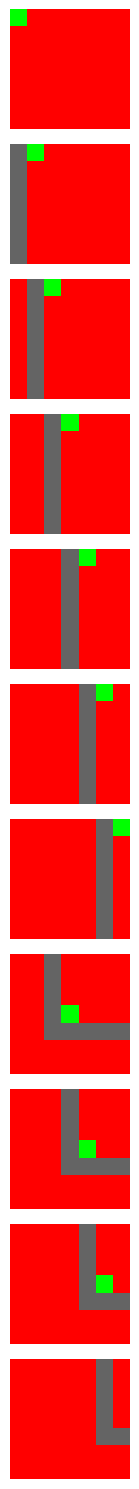

In [245]:
l = episode.observations["image"].shape[0]
fig, axs = plt.subplots(l, 1, figsize=(15, 15))
for i in range(l):
    axs[i].imshow(minigrid_to_rgb(episode.observations["image"][i]).permute(1, 2, 0))
    axs[i].axis("off")
plt.tight_layout()
plt.show()

We might want to use something smaller than 192x192. That was a reasonable size for photographs. But this is upscaled from a 7x7 grid. We don't need that much resolution. And the smaller the image, the more we can fit into a context window, which is good for episodic tasks like robotics.

In [246]:
CONTROL_PATCH_SIZE = 4

In [247]:
minigrid_image_resize = transforms.Resize(
    (CONTROL_PATCH_SIZE * 6, CONTROL_PATCH_SIZE * 6)
)

In [248]:
minigrid_to_rgb(episode.observations["image"][5]).shape

torch.Size([3, 7, 7])

In [249]:
resized_minari_grid_observation_image = minigrid_image_resize([minigrid_to_rgb(episode.observations["image"][1])])
resized_minari_grid_observation_image[0].shape

torch.Size([3, 24, 24])

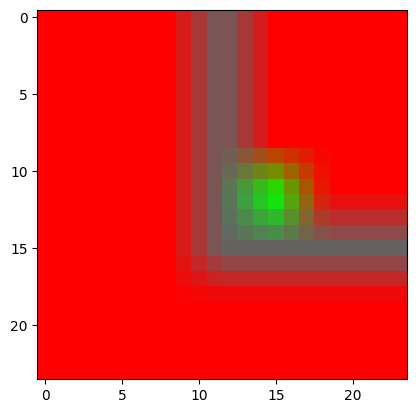

In [250]:
plt.imshow(minigrid_image_resize([minigrid_to_rgb(episode.observations["image"][8])])[0].permute(1, 2, 0))

In [251]:
episodes[0]

EpisodeData(id=468, total_steps=10, observations={direction: ndarray of shape (11,) and dtype int64, image: ndarray of shape (11, 7, 7, 3) and dtype uint8, mission: ['reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal']}, actions=ndarray of shape (10,) and dtype int64, rewards=ndarray of 10 floats, terminations=ndarray of 10 bools, truncations=ndarray of 10 bools, infos=dict with the following keys: [])

In [252]:
TokensObservation = namedtuple("TokensObservation", ["xs", "ys", "ms"])

In [253]:
def tokenize_observation(vocab_size, batch):
    xs = torch.tensor(batch, dtype=torch.int)
    xs = xs + vocab_size
    ys = torch.zeros_like(xs)  # non-textual observations aren't predicted
    ms = torch.zeros_like(ys)  # ^ ...
    return TokensObservation(xs, ys, ms)

In [254]:
TokensAction = namedtuple("TokensAction", ["xs", "ys", "ms"])

In [255]:
def tokenize_action(vocab_size, batch):
    xs = torch.tensor(batch, dtype=torch.int)
    xs = xs + vocab_size
    ys = torch.zeros_like(xs)  # non-textual observations aren't predicted
    ms = torch.zeros_like(ys)  # ^ ...
    return TokensAction(xs, ys, ms)

In [256]:
separator_token = _text_tokenizer("|")["input_ids"]
print(separator_token)
SEPARATOR_TOKEN = torch.tensor([91])

[91]


In [257]:
from collections import namedtuple
Timestep = namedtuple("Timestep", ["text", "image", "discrete", "separator", "action"])

In [258]:
def minigrid_collate_fn(tokenize_text, tokenize_image, tokenize_discrete, vocab_size, batch):
    sequenced = []
    for sample in batch:
        text_tokens = tokenize_text(
            sample.observations["mission"]
        )
        image_tokens = tokenize_image([
            minigrid_image_resize(minigrid_to_rgb(image))
            for image in sample.observations["image"]
        ])
        discrete_tokens = tokenize_observation(
            vocab_size,
            [[d] for d in sample.observations["direction"]],
        )
        action_tokens = tokenize_action(
            vocab_size,
            [[a] for a in sample.actions]
        )
        timesteps = []
        for i in range(len(sample.actions)):
            xs = Timestep(
                text_tokens.xs[i],
                image_tokens.xs[i],
                discrete_tokens.xs[i],
                SEPARATOR_TOKEN,
                action_tokens.xs[i],
            )
            ys = Timestep(
                text_tokens.ys[i],
                image_tokens.ys[i],
                discrete_tokens.ys[i],
                SEPARATOR_TOKEN,
                action_tokens.ys[i],
            )
            ms = Timestep(
                text_tokens.ms[i],
                image_tokens.ms[i],
                discrete_tokens.ms[i],
                SEPARATOR_TOKEN,
                action_tokens.ms[i],
            )
            timesteps.append([xs, ys, ms])
        sequenced.append(timesteps)
    return sequenced

In [259]:
discrete_tokens = tokenize_observation(
    VOCAB_SIZE,
    minigrid_dataset[0].observations["direction"]
)
discrete_tokens
# minigrid_dataset[0].observations["direction"]

TokensObservation(xs=tensor([50257, 50258, 50259, 50259, 50259, 50259, 50259, 50259, 50260, 50260,
        50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260],
       dtype=torch.int32), ys=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32), ms=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32))

In [260]:
sample = minigrid_dataset[0]

In [261]:
image = sample.observations["image"][0:4]
image.shape

(4, 7, 7, 3)

In [262]:
images_resized = torch.stack([minigrid_image_resize(minigrid_to_rgb(i)) for i in image])

In [263]:
images_to_patches(images_resized, CONTROL_PATCH_SIZE).shape

torch.Size([4, 36, 48])

In [271]:
images_resized.shape

torch.Size([4, 3, 24, 24])

In [274]:
tokens = tokenize_image(images_resized, patch_size=CONTROL_PATCH_SIZE)

In [277]:
tokens.xs.shape, tokens.ys.shape

(torch.Size([4, 36, 48]), torch.Size([4, 36]))

In [293]:
int((tokens.xs.size(2) / 3) ** 0.5)

4

In [279]:
xs = tokens.xs

In [ ]:
n_patch_rows, n_patch_cols = n_patch_rows_cols(self.patch_size, self.patch_size, heights, widths)
images_embeddings = []
embeddings = self.resnet(tokens)
for i, token in enumerate(tokens):
    row_interval, col_interval = intervals(n_patch_rows[i].item(), n_patch_cols[i].item())
    image_embeddings = []
    for j in range(image.size(0)):
        row_idx, col_idx = patch_position_sample(row_interval, col_interval, j, mode="training")
        embeddings[i][j] += _patch_position_row_embedding(row_idx) + _patch_position_col_embedding(col_idx)  

In [193]:
# [1, 36, 48]
# 1 batch
#     36 patches
#         4x4x3 HxWxC
image_tokens.xs.shape

torch.Size([1, 36, 48])

In [196]:
ctrl_dataloader = DataLoader(
    minigrid_dataset, 
    batch_size=BATCH_SIZE,
    collate_fn=partial(
        minigrid_collate_fn, 
        partial(tokenize_text, _text_tokenizer), 
        partial(tokenize_image),
        partial(tokenize_observation, _text_tokenizer.vocab_size),
        _text_tokenizer.vocab_size,
    ),
    num_workers=NUM_WORKERS,
)

In [197]:
batch = next(iter(ctrl_dataloader))

In [198]:
len(batch)

4

In [199]:
# batch[0] is the first sample of the batch; an episode
len(batch[0])

19

In [200]:
# batch[0][0] is the first timestep of the first episode

In [201]:
torch.tensor([1]).size(0)

1

In [202]:
[t.size(0) for t in batch[0][0][0]._asdict().values()]

[1024, 36, 1, 1, 1]

In [203]:
batch[0][0][1]

Timestep(text=tensor([  262,  3061, 50256,  ..., 50256, 50256, 50256]), image=tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), discrete=tensor([0], dtype=torch.int32), separator=tensor([91]), action=tensor([0], dtype=torch.int32))

In [204]:
# batch[0][0][0] is the xs of the first timestep
# batch[0][0][1] is the ys
#            [2] is the ms
batch[0][0][0]

Timestep(text=tensor([16250,   262,  3061,  ..., 50256, 50256, 50256]), image=tensor([[-0.0011, -0.0011, -0.0011,  ..., -0.2887, -0.2887, -0.2887],
        [-0.0011, -0.0011, -0.0011,  ..., -0.2887, -0.2887, -0.2887],
        [-0.0011, -0.0962, -0.1981,  ..., -0.2276, -0.1619, -0.0962],
        ...,
        [-0.2670, -0.2670, -0.2670,  ..., -0.0629, -0.0629, -0.0629],
        [-0.2670, -0.2670, -0.2670,  ..., -0.0629, -0.0629, -0.0629],
        [-0.2670, -0.2670, -0.2670,  ..., -0.0629, -0.0629, -0.0629]]), discrete=tensor([50257], dtype=torch.int32), separator=tensor([91]), action=tensor([50258], dtype=torch.int32))

In [205]:
batch[0][0][0].image.shape

torch.Size([36, 48])

In [206]:
import torch.nn as nn

In [207]:
EMBEDDING_DIM = 432

In [208]:
# From section 2.2 of the Gato paper:
#
#    Tokens belonging to image patches for any time-step are embedded using a
#    single ResNet (He et al., 2016a) block to obtain a vector per patch. For
#    image patch token embeddings, we also add a learnable within-image position
#    encoding vector.
class ResNetV2Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, num_groups=24):
        super(ResNetV2Block, self).__init__()
        self.gn1 = nn.GroupNorm(1, in_channels)
        self.gelu = nn.GELU()
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.gn2 = nn.GroupNorm(num_groups, out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False
        )

    def forward(self, x):
        B, T, CHW = x.shape
        # TODO: Remove these hardcoded values.
        out = rearrange(x, 'b t (c h w) -> (b t) c h w', c=3, h=16)
        out = self.gn1(out)
        out = self.gelu(out)
        out = self.conv1(out)
        out = self.gn2(out)
        out = self.gelu(out)
        out = self.conv2(out)
        return x + rearrange(out, '(b t) c h w -> b t (c h w)', b=B, t=T)

_image_embedding = ResNetV2Block(3, EMBEDDING_DIM)
# This _position_embedding doesn't match exactly what's in the Gato paper.
# The gato/policy/embeddings.py file has the exact implementation from the paper.
# https://github.com/eihli/NEKO/blob/explore-simplify-dataset-dataloader/gato/policy/embeddings.py#L91

In [209]:
def num_patches(patch_size, image_dim):
    return (image_dim / patch_size).to(torch.uint8)

In [119]:
class MiniGato(nn.Module):
    def __init__(
        self,
        sequence_length,
        embedding_dims,
        vocab_size,
        text_tokenizer=None,
        patch_size=12,
    ):
        assert text_tokenizer, "text_tokenizer is a required arg"

        self.sequence_length = sequence_length
        self.embedding_dim = embedding_dims
        self.patch_size = patch_size
        self.text_tokenizer = text_tokenizer
        
        self.text_embedding = nn.Embedding(
            self.vocab_size,
            self.embedding_dim,
        )
        self.resnet = ResNetV2Block(3, self.embedding_dims)
        self.row_embedding = nn.Embedding(128, self.embedding_dim)
        self.col_embedding = nn.Embedding(128, self.embedding_dim)
        self.timestep_position_embedding = nn.Embedding(512, self.embedding_dim)
        self.discrete_embedding = nn.Embedding(
            1024,  # Number of discrete bins.
            self.embedding_dim,
        )
        
        self.configuration = GPT2Config(
            n_layer=2,
            n_head=2,
            n_embd=self.embedding_dim
        )
        self.transformer = GPT2Model(configuration)        

        self.lm_head = nn.Linear(model.config.hidden_size, _text_tokenizer.vocab_size).to(device)

    @property
    def vocab_size(self):
        return self.text_tokenizer.vocab_size

    def embed_text(self, tokens):
        return self.text_embedding(tokens)["input_ids"]

    def embed_image(self, tokens):
        if not tokens:
            return torch.tensor()
        # [        heights,         widths]
        # [[640, 640, 640], [480, 480, 480]]
        heights, widths = torch.tensor([[tokens.size(1)], [tokens.size(2)]]).repeat(1, tokens.size(0))
        
        n_patch_rows, n_patch_cols = n_patch_rows_cols(self.patch_size, self.patch_size, heights, widths)
        images_embeddings = []
        embeddings = self.resnet(tokens)
        for i, token in enumerate(tokens):
            row_interval, col_interval = intervals(n_patch_rows[i].item(), n_patch_cols[i].item())
            image_embeddings = []
            for j in range(image.size(0)):
                row_idx, col_idx = patch_position_sample(row_interval, col_interval, j, mode="training")
                embeddings[i][j] += _patch_position_row_embedding(row_idx) + _patch_position_col_embedding(col_idx)        
        return embed_image(n_patch_rows, n_patch_cols, tokens)

    def forward(self, xs):
        pass

In [ ]:
def embed_image(n_patch_rows, n_patch_cols, images):
    images_embeddings = []
    embeddings = self.resnet(images)
    for i, image in enumerate(images):
        row_interval, col_interval = intervals(n_patch_rows[i].item(), n_patch_cols[i].item())
        image_embeddings = []
        for j in range(image.size(0)):
            row_idx, col_idx = patch_position_sample(row_interval, col_interval, j, mode="training")
            embeddings[i][j] += _patch_position_row_embedding(row_idx) + _patch_position_col_embedding(col_idx)
    return embeddings

In [115]:
image = torch.ones((4, 640, 480))
torch.tensor([[i] for i in image.shape[1:3]]).repeat(1, 5)

tensor([[640, 640, 640, 640, 640],
        [480, 480, 480, 480, 480]])